In [49]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import h5py
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig, load_fm_config
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data_path = "/home/pere/code/cofilin-repo/z_recs/phiweb_pl/N128_R14_PhiDeltaWeb_HighPassPowerLaw_NegBinomial_SQ1/data/mock.hdf5"
fit_path = "/home/pere/code/cofilin-repo/z_recs/phiweb_pl/N128_R14_PhiDeltaWeb_HighPassPowerLaw_NegBinomial_SQ1/TEST1/CH01/sample.hdf5"
fm_cfg_path = "/home/pere/code/cofilin-repo/z_recs/phiweb_pl/N128_R14_PhiDeltaWeb_HighPassPowerLaw_NegBinomial_SQ1/data/fm_config.json"

fm_cfg = load_fm_config(fm_cfg_path)
cte = Constants(fm_cfg.N, fm_cfg.L, fm_cfg.Z_I, fm_cfg.Z_F)
fmodel = FModel(fm_cfg)

params_path = "/home/pere/code/cofilin-repo/z_recs/phiweb_pl/N128_R14_PhiDeltaWeb_HighPassPowerLaw_NegBinomial_SQ1/data/params.json"

with open(params_path, 'r', encoding='utf-8') as f:
    data_params = json.load(f)

with h5py.File(data_path) as f:
    q_ref = jnp.array(f["input"][:])
    din_ref = jnp.array(f["din"][:])
    n_tr_data = jnp.array(f["n_tr_data"][:])

with h5py.File(fit_path) as f:
    params = f["params"]
    q = params["q"][:]
    alpha = params["alpha"][:]
    beta = params["beta"][:]
    rho_hp = params["rho_hp"][:]
    e_hp = params["e_hp"][:]

fitted_params = {
    "alpha": alpha, 
    "beta": beta, 
    "rho_hp": rho_hp, 
    "e_hp": e_hp, 
}

params_init = {
    "alpha": jnp.array([1, 1, 1, 1.0] * 4),
    "beta": jnp.array([10, 10, 10, 10.0] * 4),
    "e_hp": jnp.array([1, 1, 1, 1.0] * 4),
    "rho_hp": jnp.array([1, 1, 1, 1.0] * 4),
}

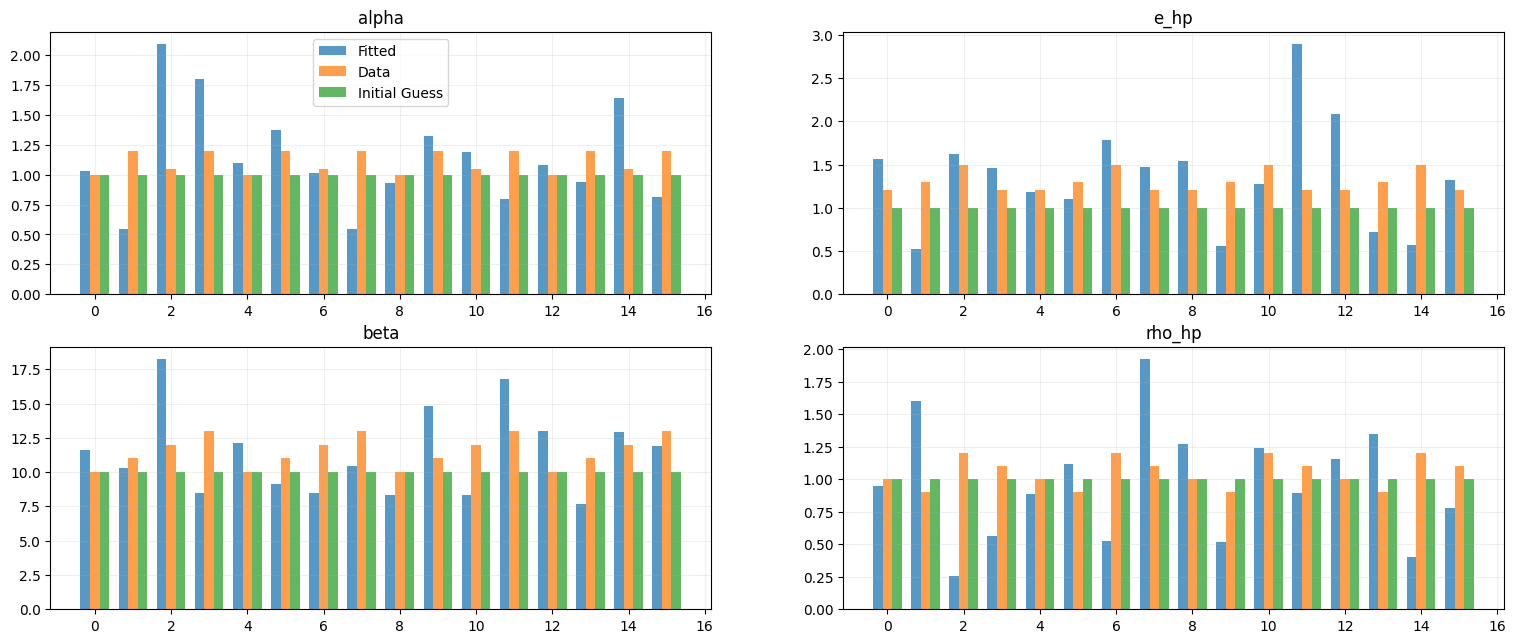

In [38]:
fs, rat = 7.5, 2.5
fig, axs = plt.subplots(2, 2, figsize=(fs*rat, fs))

x = jnp.arange(16)

alpha = 0.75
width=0.25
axs[0,0].bar(x - width, fitted_params['alpha'], width=width, alpha=alpha, label='Fitted')
axs[0,0].bar(x, data_params['alpha'], width=width, alpha=alpha, label='Data')
axs[0,0].bar(x + width, params_init['alpha'], width=width, alpha=alpha, label='Initial Guess')
axs[0,0].set_title('alpha')

axs[0,1].bar(x - width, fitted_params['e_hp'], width=width, alpha=alpha, label='Fitted')
axs[0,1].bar(x, data_params['e_hp'], width=width, alpha=alpha, label='Data')
axs[0,1].bar(x + width, params_init['e_hp'], width=width, alpha=alpha, label='Initial Guess')
axs[0,1].set_title('e_hp')

axs[1,1].bar(x - width, fitted_params['rho_hp'], width=width, alpha=alpha, label='Fitted')
axs[1,1].bar(x, data_params['rho_hp'], width=width, alpha=alpha, label='Data')
axs[1,1].bar(x + width, params_init['rho_hp'], width=width, alpha=alpha, label='Initial Guess')
axs[1,1].set_title('rho_hp')

axs[1,0].bar(x - width, fitted_params['beta'], width=width, alpha=alpha, label='Fitted')
axs[1,0].bar(x, data_params['beta'], width=width, alpha=alpha, label='Data')
axs[1,0].bar(x + width, params_init['beta'], width=width, alpha=alpha, label='Initial Guess')
axs[1,0].set_title('beta')

for ax in axs.ravel():
    ax.grid(True, alpha=0.2)

axs[0,0].legend()

In [40]:
din = my_ifft(fmodel.delta_in(q), cte.INV_L3)

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

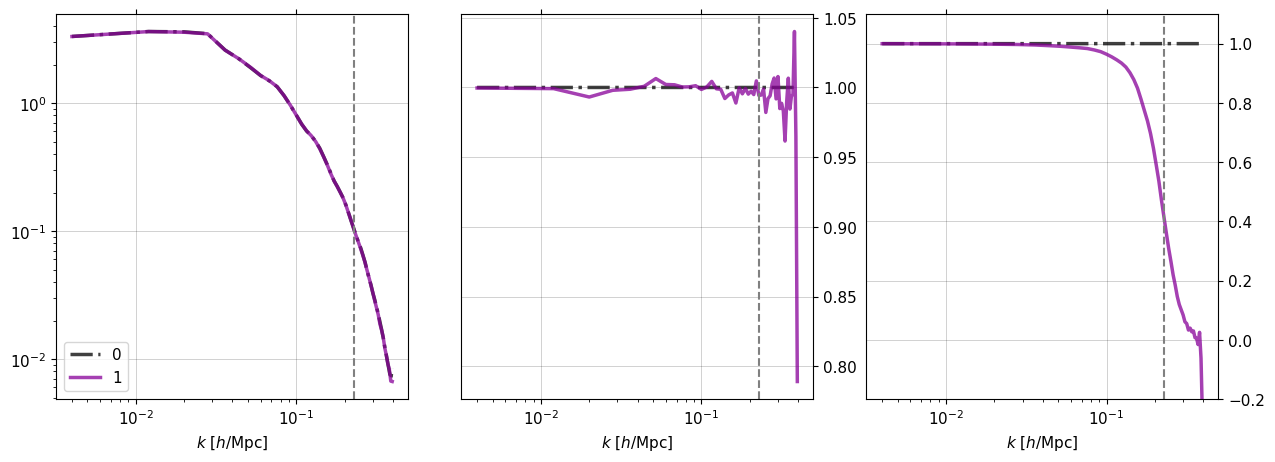

In [43]:
compare_pow_spec([din_ref, din], L=cte.L, n_bins=50, xlog=True)

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

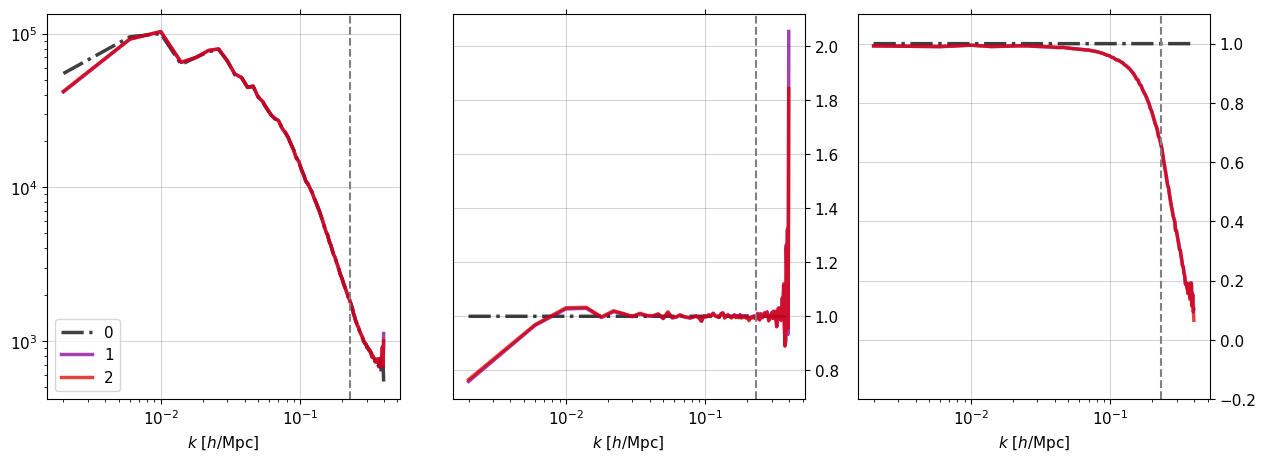

In [51]:
q_fit=q
delta_in_fit = my_ifft(fmodel.delta_in(q_fit), cte.INV_L3)
delta_lpt_fit = fmodel.delta_lpt(q_fit)
cweb_arr = fmodel.cweb(delta_lpt_fit)
get_n_tr_mean = fmodel.n_tr_mean()

n_tr_mean_fit = get_n_tr_mean(delta_lpt_fit, fitted_params, cweb_arr)
key_sample = jax.random.PRNGKey(101)
n_tr_fit = fmodel.sample_n_tr(
    n_tr_mean_fit, key_sample, params=fitted_params, cweb=cweb_arr
)

data_params = manage_params(data_params)
n_tr_mean_fit2 = get_n_tr_mean(delta_lpt_fit, data_params, cweb_arr)
key_sample = jax.random.PRNGKey(101)
n_tr_fit2 = fmodel.sample_n_tr(
    n_tr_mean_fit2, key_sample, params=data_params, cweb=cweb_arr
)

delta_n_tr_data = n_tr_data * cte.N**3 / n_tr_data.sum() - 1
delta_n_tr_fit = n_tr_fit * cte.N**3 / n_tr_fit.sum() - 1
delta_n_tr_fit2 = n_tr_fit2 * cte.N**3 / n_tr_fit2.sum() - 1

compare_pow_spec([delta_n_tr_data, delta_n_tr_fit, delta_n_tr_fit2], L=cte.L, n_bins=100, xlog=True)